
## COVID-CT Grand Challenge ##

Coronavirus disease 2019 (COVID-19) has infected more than 1.3 million individuals all over the world and caused more than 106,000 deaths. One major hurdle in controlling the spreading of this disease is the inefficiency and shortage of medical tests. To mitigate the inefficiency and shortage of existing tests for COVID-19, we propose this competition to encourage the development of effective Deep Learning techniques  to diagnose COVID-19 based on CT images.  The problem in this challenge is to classify each CT image into positive COVID-19 (the image has  clinical findings of COVID-19) or negative COVID-19 ( the image does not have clinical findings of COVID-19). It’s a binary classification problem based on CT images.

[Guthub Repository](https://github.com/UCSD-AI4H/COVID-CT)

[COVID-CT Grand Challenge](https://covid-ct.grand-challenge.org/)

### Load the dataset ###

Load the train, valid and test dataset directly from S3.


In [1]:
!curl -o ct-grand-challenge-colab.zip https://us-east-1-colab-data.s3.amazonaws.com/ct-grand-challenge-colab.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  482M  100  482M    0     0  41.6M      0  0:00:11  0:00:11 --:--:-- 45.2M


In [ ]:
!unzip ct-grand-challenge-colab.zip
!mv ./baseline\ methods/DenseNet121-UFF/util.py .

Archive:  ct-grand-challenge-colab.zip
  inflating: COVID-CT-MetaInfo.xlsx  
  inflating: densenet.hdf5           
  inflating: NonCOVID-CT-MetaInfo.csv  
   creating: Data-split/
   creating: Data-split/COVID/
  inflating: Data-split/COVID/testCT_COVID.txt  
  inflating: Data-split/COVID/trainCT_COVID.txt  
  inflating: Data-split/COVID/valCT_COVID.txt  
   creating: Data-split/NonCOVID/
  inflating: Data-split/NonCOVID/CT_NonCOVID_test_id.csv  
  inflating: Data-split/NonCOVID/CT_NonCOVID_train_id.csv  
  inflating: Data-split/NonCOVID/CT_NonCOVID_val_id.csv  
  inflating: Data-split/NonCOVID/testCT_NonCOVID.txt  
  inflating: Data-split/NonCOVID/trainCT_NonCOVID.txt  
  inflating: Data-split/NonCOVID/valCT_NonCOVID.txt  
   creating: Images-processed/
   creating: Images-processed/CT_COVID/
  inflating: Images-processed/CT_COVID/2019-novel-Coronavirus-severe-adult-respiratory-dist_2020_International-Jour-p3-89%0.png  
  inflating: Images-processed/CT_COVID/2019-novel-Coronavirus-sev

### Load libraries

In [ ]:
# General
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Keras DNN
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121, DenseNet169, DenseNet201
from keras.layers import Dense, GlobalAveragePooling2D, GlobalMaxPooling2D, Dropout
from keras.models import Model
from keras import backend as K
from keras.metrics import SensitivityAtSpecificity, TruePositives, Accuracy, BinaryAccuracy
from keras.losses import BinaryCrossentropy
from keras.layers import Flatten
from keras.models import load_model
from keras.optimizers import Adam
from keras.callbacks import TensorBoard, ModelCheckpoint

# Metrics
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn import metrics

# Util
import util
import datetime

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


### 1 - Preprocessing

In [ ]:
# covid
covid_train = pd.read_csv('./Data-split/COVID/trainCT_COVID.txt', names=["File name"])
covid_train["Target"] = 1

covid_val = pd.read_csv('./Data-split/COVID/valCT_COVID.txt', names=["File name"])
covid_val["Target"] = 1

covid_test = pd.read_csv('./Data-split/COVID/testCT_COVID.txt', names=["File name"])
covid_test["Target"] = 1

# non covid
non_covid_train = pd.read_csv('./Data-split/NonCOVID/trainCT_NonCOVID.txt', names=["File name"])
non_covid_train["Target"] = 0

non_covid_val = pd.read_csv('./Data-split/NonCOVID/valCT_NonCOVID.txt', names=["File name"])
non_covid_val["Target"] = 0

non_covid_test = pd.read_csv('./Data-split/NonCOVID/testCT_NonCOVID.txt', names=["File name"])
non_covid_test["Target"] = 0

print(covid_train.shape)
print(covid_val.shape)
print(covid_test.shape)
print("")
print(non_covid_train.shape)
print(non_covid_val.shape)
print(non_covid_test.shape)
print("")
print("Train: ", covid_train.shape[0] + non_covid_train.shape[0])
print("Val: ", covid_val.shape[0] + non_covid_val.shape[0])
print("Test: ",covid_test.shape[0] + non_covid_test.shape[0])

(191, 2)
(60, 2)
(98, 2)

(234, 2)
(58, 2)
(105, 2)

Train:  425
Val:  118
Test:  203


In [ ]:
# MetaInfo - Patient ID
import sys
covid_metainfo = pd.read_excel("./COVID-CT-MetaInfo.xlsx", encoding='uft8')
covid_metainfo.dropna(subset=['File name'], inplace=True)

non_covid_metainfo = pd.read_csv("./NonCOVID-CT-MetaInfo.csv")
non_covid_metainfo.rename(columns={"image name": "File name", "patient id": "Patient ID"}, inplace=True)
non_covid_metainfo.dropna(subset=['File name'], inplace=True)
non_covid_metainfo.drop(columns=['Unnamed: 0'], inplace=True)

# Remove unused columns
covid_metainfo.drop(columns=['Age', 'Captions', 'Gender', 'Location', 'Medical history', 'Severity', 'Time', 'DOI', 'Other diseases'], inplace=True)

print(covid_metainfo.shape)
print(non_covid_metainfo.shape)

(349, 2)
(397, 2)


In [ ]:
# Dados unicos metainfo
print("Covid MetaInfo Unique",covid_metainfo["File name"].unique().shape)
print("Covid Metainfo",covid_metainfo["File name"].shape)
print("")
print("Non Covid Metainfo Unique",non_covid_metainfo["File name"].unique().shape)
print("NOn Covid Metainfo",non_covid_metainfo["File name"].shape)

Covid MetaInfo Unique (349,)
Covid Metainfo (349,)

Non Covid Metainfo Unique (397,)
NOn Covid Metainfo (397,)


In [ ]:
# Merge Covid
covid_train_merge = pd.merge(covid_train, covid_metainfo, on=['File name'])
covid_val_merge = pd.merge(covid_val, covid_metainfo, on=['File name'])
covid_test_merge = pd.merge(covid_test, covid_metainfo, on=['File name'])

print(covid_test.shape, covid_metainfo.shape)

# stats - shape
print("\nCovid Data")
print(covid_train_merge.shape)
print(covid_val_merge.shape)
print(covid_test_merge.shape)

print(covid_train_merge.shape)
print(covid_test_merge.shape)

(98, 2) (349, 2)

Covid Data
(191, 3)
(60, 3)
(98, 3)
(191, 3)
(98, 3)


In [ ]:
# Merge Non Covid
non_covid_train_merge = pd.merge(non_covid_train, non_covid_metainfo, on=['File name'])
non_covid_val_merge = pd.merge(non_covid_val, non_covid_metainfo, on=['File name'])
non_covid_test_merge = pd.merge(non_covid_test, non_covid_metainfo, on=['File name'])

# stats - shape
print("\nCovid Data")
print(non_covid_train.shape)
print(non_covid_val.shape)
print(non_covid_test.shape)


Covid Data
(234, 2)
(58, 2)
(105, 2)


In [ ]:
# Concate
print(covid_test_merge.shape)
print(non_covid_test_merge.shape)

train_df = pd.concat([covid_train_merge, non_covid_train_merge])
val_df = pd.concat([covid_val_merge, non_covid_val_merge])
test_df = pd.concat([covid_test_merge, non_covid_test_merge])

print("\nNon Covid Data")
print(non_covid_train.shape)
print(non_covid_val.shape)
print(non_covid_test.shape)

(98, 3)
(105, 3)

Non Covid Data
(234, 2)
(58, 2)
(105, 2)


In [ ]:
print("\nConcate Data")
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)


Concate Data
(425, 3)
(118, 3)
(203, 3)


In [ ]:
print("\nTrain Head")
print(train_df.head())
print("")
print("\nTrain Tail")
print(train_df.tail())


Train Head
                         File name  Target Patient ID
0    2020.01.24.919183-p27-132.png       1  Patient 1
1    2020.01.24.919183-p27-133.png       1  Patient 1
2    2020.01.24.919183-p27-134.png       1  Patient 1
3    2020.01.24.919183-p27-135.png       1  Patient 1
4  2020.02.10.20021584-p6-52%0.png       1  Patient 2


Train Tail
    File name  Target          Patient ID
229  89%2.jpg       0  crawled_patient_89
230  89%3.jpg       0  crawled_patient_89
231    90.jpg       0  crawled_patient_90
232  91%0.jpg       0  crawled_patient_91
233  91%1.jpg       0  crawled_patient_91


### 2 - Image Visualization

Loading original image


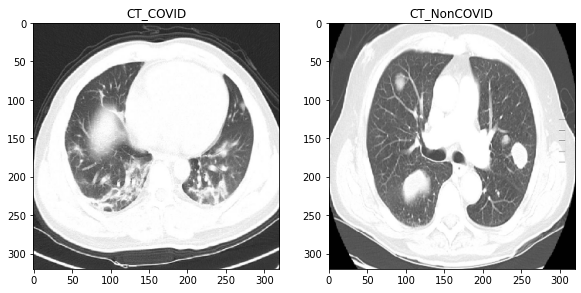

In [ ]:
# print first covid image
print("Loading original image")
ct_covid_img = "./Images-processed/CT_COVID/"
non_ct_covid_img = "./Images-processed/CT_NonCOVID/"

plt.figure(figsize=(15, 10))
plt.subplot(131 + 1)
plt.title('CT_COVID')
plt.imshow(util.load_simple_image(image_dir=f"{ct_covid_img}", img=covid_train["File name"][0]), cmap='gray')
plt.subplot(131 + 2)
plt.title('CT_NonCOVID')
plt.imshow(util.load_simple_image(image_dir=f"{non_ct_covid_img}", img=non_covid_train["File name"][0]), cmap='gray')

In [ ]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for training set, normalizing using batch
    statistics.

    Args:
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        train_generator (DataFrameIterator): iterator over training set
    """        
    print("getting train generator...")
    # normalize images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)
    
    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator

In [ ]:
print("Final shapes")
print("Train: ", train_df.shape)
print("Val: ", val_df.shape)
print("Test: ", test_df.shape)

Final shapes
Train:  (425, 3)
Val:  (118, 3)
Test:  (203, 3)


In [ ]:
train_df.head()

,File name,Target,Patient ID
0,2020.01.24.919183-p27-132.png,1,Patient 1
1,2020.01.24.919183-p27-133.png,1,Patient 1
2,2020.01.24.919183-p27-134.png,1,Patient 1
3,2020.01.24.919183-p27-135.png,1,Patient 1
4,2020.02.10.20021584-p6-52%0.png,1,Patient 2


In [ ]:
val_df.head()

,File name,Target,Patient ID
0,2020.03.13.20035212-p23-155.png,1,Patient 131
1,2020.03.13.20035212-p23-156.png,1,Patient 132
2,2020.03.13.20035212-p23-157.png,1,Patient 133
3,2020.03.13.20035212-p23-158.png,1,Patient 134
4,2020.03.13.20035212-p23-159.png,1,Patient 135


In [ ]:
test_df.head()

,File name,Target,Patient ID
0,2020.03.22.20040782-p25-1542.png,1,Patient 163
1,2020.03.22.20040782-p25-1543.png,1,Patient 164
2,2020.03.22.20040782-p25-1544.png,1,Patient 165
3,2020.03.22.20040782-p25-1545.png,1,Patient 166
4,2020.03.22.20040782-p25-1546.png,1,Patient 167


### 3 - Data Leakage

In [ ]:
# UNQ_C1 (UNIQUE CELL IDENTIFIER, DO NOT EDIT)
def check_for_leakage(df1, df2, patient_col):
    """
    Return True if there any patients are in both df1 and df2.

    Args:
        df1 (dataframe): dataframe describing first dataset
        df2 (dataframe): dataframe describing second dataset
        patient_col (str): string name of column with patient IDs
    
    Returns:
        leakage (bool): True if there is leakage, otherwise False
    """

    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    
    df1_patients_unique = set(df1[patient_col])
    df2_patients_unique = set(df2[patient_col])
    
    patients_in_both_groups = list(df1_patients_unique.intersection(df2_patients_unique))

    # leakage contains true if there is patient overlap, otherwise false.
    leakage = (len(patients_in_both_groups) > 0) # boolean (true if there is at least 1 patient in both groups)
    
    ### END CODE HERE ###
    
    return leakage

In [ ]:
print("leakage between train and test: {}".format(check_for_leakage(train_df, test_df, 'Patient ID')))
print("leakage between valid and test: {}".format(check_for_leakage(val_df, test_df, 'Patient ID')))

leakage between train and test: False
leakage between valid and test: False


### 4 - Preparing Images

In [ ]:
def get_train_generator(df, image_dir, x_col, y_cols, shuffle=True, batch_size=8, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for training set, normalizing using batch
    statistics.

    Args:
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        train_generator (DataFrameIterator): iterator over training set
    """        
    print("getting train generator...") 
    # normalize images
    image_generator = ImageDataGenerator(
        samplewise_center=True,
        samplewise_std_normalization= True)
    
    # flow from directory with specified batch size
    # and target image size
    generator = image_generator.flow_from_dataframe(
            dataframe=df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=shuffle,
            seed=seed,
            target_size=(target_w,target_h))
    
    return generator

In [ ]:
def get_test_and_valid_generator(valid_df, test_df, train_df, image_dir, x_col, y_cols, sample_size=100, batch_size=8, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for validation set and test test set using 
    normalization statistics from training set.

    Args:
      valid_df (dataframe): dataframe specifying validation data.
      test_df (dataframe): dataframe specifying test data.
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    
    Returns:
        test_generator (DataFrameIterator) and valid_generator: iterators over test set and validation set respectively
    """
    print("getting train and valid generators...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe=train_df, 
        directory=IMAGE_DIR, 
        x_col=x_col, 
        y_col=y_cols, 
        class_mode="raw", 
        batch_size=sample_size, 
        shuffle=True, 
        target_size=(target_w, target_h))
    
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization= True)
    
    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe=valid_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe=test_df,
            directory=image_dir,
            x_col=x_col,
            y_col=y_cols,
            class_mode="raw",
            batch_size=batch_size,
            shuffle=False,
            seed=seed,
            target_size=(target_w,target_h))
    return valid_generator, test_generator

In [ ]:
IMAGE_DIR = "./Images-processed/Images/"
train_generator = get_train_generator(train_df, IMAGE_DIR, "File name", ["Target"])
valid_generator, test_generator = get_test_and_valid_generator(val_df, test_df, train_df, IMAGE_DIR, "File name", ["Target"])

getting train generator...
Found 425 validated image filenames.
getting train and valid generators...
Found 425 validated image filenames.
Found 118 validated image filenames.
Found 203 validated image filenames.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


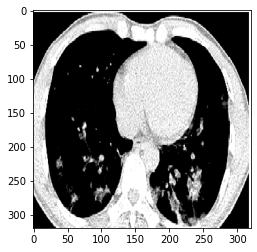

In [ ]:
x, y = train_generator.__getitem__(0)
plt.imshow(x[0]);

### 5 - Model Development

#### Addressing Class Imbalance

(array([234.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0., 191.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <a list of 10 Patch objects>)

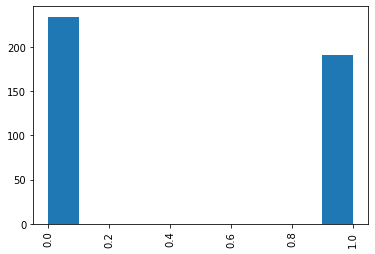

In [ ]:
plt.xticks(rotation=90)
plt.hist(train_df["Target"])

In [ ]:
print("Número de casos com COVID na base de treinamento ", train_df[train_df["Target"] == 1].shape[0])
print("Número de casos sem COVID na base de treinamento ", train_df[train_df["Target"] == 0].shape[0])

print("Peso COVID: ", train_df[train_df["Target"] == 1].shape[0] / train_df["Target"].shape[0])
print("Peso s/ COVID: ", train_df[train_df["Target"] == 0].shape[0] / train_df["Target"].shape[0])

Número de casos com COVID na base de treinamento  191
Número de casos sem COVID na base de treinamento  234
Peso COVID:  0.44941176470588234
Peso s/ COVID:  0.5505882352941176


### DensetNet121 #3

Congelando os pesos da rede, treinando somente as últimas camadas. Utilizando um dense layer com 32 neurônios e um dropout de 20%. Learning rating baixo, buscando tentar realizar o aprendizado lentamente.

In [ ]:
# create the base pre-trained model
base_model = DenseNet121(weights='./densenet.hdf5', include_top=False)

# mark loaded layers as not trainable
for layer in base_model.layers:
	layer.trainable = False

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# add a dense layer #1
x = Dense(32, activation='relu')(x)

# add a dropout layer
x = Dropout(0.5)(x)

# and a logistic layer
predictions = Dense(1, activation="sigmoid")(x)

NameError: ignored

In [ ]:
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss=BinaryCrossentropy(), metrics=[BinaryAccuracy()])

NameError: ignored

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_3 (ZeroPadding2D (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d_3[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
# Checkpoint
filepath="model-2-weights-improvement-{epoch:02d}-{val_binary_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_binary_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Generator Params
BS=8 
EPOCHS= 30
STEPS_PER_EPOCH=train_df.shape[0]//BS
VALIDATION_STEPS=val_df.shape[0]//BS

# Fit
history = model.fit_generator(train_generator, 
                              validation_data=valid_generator,
                              steps_per_epoch=100, 
                              validation_steps=VALIDATION_STEPS, 
                              epochs = EPOCHS,
                              callbacks=callbacks_list)

Epoch 1/30
100/100 [==============================] - 28s 283ms/step - loss: 0.6939 - binary_accuracy: 0.5980 - val_loss: 0.6664 - val_binary_accuracy: 0.4732

Epoch 00001: val_binary_accuracy improved from -inf to 0.47321, saving model to model-2-weights-improvement-01-0.47.hdf5
Epoch 2/30
100/100 [==============================] - 21s 206ms/step - loss: 0.6184 - binary_accuracy: 0.6883 - val_loss: 0.5317 - val_binary_accuracy: 0.5273

Epoch 00002: val_binary_accuracy improved from 0.47321 to 0.52727, saving model to model-2-weights-improvement-02-0.53.hdf5
Epoch 3/30
100/100 [==============================] - 21s 208ms/step - loss: 0.5613 - binary_accuracy: 0.7048 - val_loss: 0.6955 - val_binary_accuracy: 0.5182

Epoch 00003: val_binary_accuracy did not improve from 0.52727
Epoch 4/30
100/100 [==============================] - 21s 207ms/step - loss: 0.5417 - binary_accuracy: 0.7264 - val_loss: 0.8729 - val_binary_accuracy: 0.6182

Epoch 00004: val_binary_accuracy improved from 0.5272

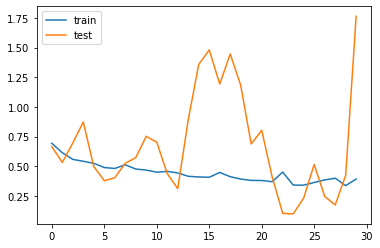

In [ ]:
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
model.load_weights("model-2-weights-improvement-19-0.67.hdf5")
predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))

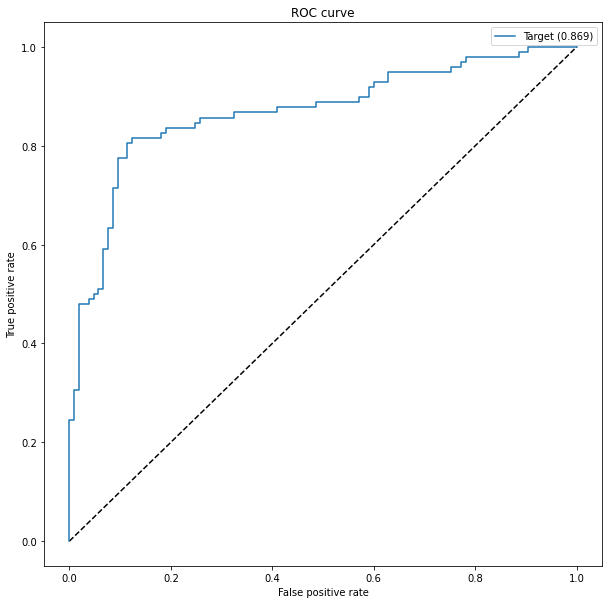

In [ ]:
auc_rocs = util.get_roc_curve(["Target"], predicted_vals, test_generator)

In [ ]:
gt = test_generator.labels[:, 0]
pred = predicted_vals[:, 0]
print(metrics.classification_report(gt, pred.round()))

              precision    recall  f1-score   support

           0       0.88      0.36      0.51       105
           1       0.58      0.95      0.72        98

    accuracy                           0.65       203
   macro avg       0.73      0.66      0.62       203
weighted avg       0.74      0.65      0.61       203



In [ ]:
f1_score = metrics.f1_score(gt, pred.round(), pos_label=1)
f1_score

0.7209302325581397

In [ ]:
accuracy_score = metrics.accuracy_score(gt, pred.round(), normalize=True)
accuracy_score

0.645320197044335

In [ ]:
tn, fp, fn, tp = metrics.confusion_matrix(gt, pred.round()).ravel()
sensitivity = tp / (tp+fn)
specificity = tn / (tn+fp)

In [ ]:
sensitivity

0.9489795918367347

In [ ]:
specificity

0.3619047619047619

In [ ]:
# create the base pre-trained model
base_model = DenseNet121(weights='./densenet.hdf5', include_top=False)

#mark loaded layers as not trainable
for layer in base_model.layers:
	layer.trainable = False

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# add a dense layer #1
x = Dense(64, activation='relu')(x)

# add a dropout layer
x = Dropout(0.5)(x)

# and a logistic layer
predictions = Dense(1, activation="sigmoid")(x)

In [ ]:
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss=BinaryCrossentropy(), metrics=[BinaryAccuracy()])

In [ ]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_7 (ZeroPadding2D (None, None, None, 3 0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d_7[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
# Checkpoint
filepath="model-3-weights-improvement-{epoch:02d}-{val_binary_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_binary_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Generator Params
BS=8 
EPOCHS= 30
STEPS_PER_EPOCH=train_df.shape[0]//BS
VALIDATION_STEPS=val_df.shape[0]//BS

# Fit
history = model.fit_generator(train_generator, 
                              validation_data=valid_generator,
                              steps_per_epoch=100, 
                              validation_steps=VALIDATION_STEPS, 
                              epochs = EPOCHS,
                              callbacks=callbacks_list)

Epoch 1/30
100/100 [==============================] - 29s 295ms/step - loss: 0.7190 - binary_accuracy: 0.6260 - val_loss: 0.9109 - val_binary_accuracy: 0.5804

Epoch 00001: val_binary_accuracy improved from -inf to 0.58036, saving model to model-3-weights-improvement-01-0.58.hdf5
Epoch 2/30
100/100 [==============================] - 20s 205ms/step - loss: 0.5613 - binary_accuracy: 0.7252 - val_loss: 0.3547 - val_binary_accuracy: 0.4727

Epoch 00002: val_binary_accuracy did not improve from 0.58036
Epoch 3/30
100/100 [==============================] - 20s 204ms/step - loss: 0.5419 - binary_accuracy: 0.7201 - val_loss: 0.9220 - val_binary_accuracy: 0.5818

Epoch 00003: val_binary_accuracy improved from 0.58036 to 0.58182, saving model to model-3-weights-improvement-03-0.58.hdf5
Epoch 4/30
100/100 [==============================] - 21s 205ms/step - loss: 0.4955 - binary_accuracy: 0.7545 - val_loss: 0.6782 - val_binary_accuracy: 0.6818

Epoch 00004: val_binary_accuracy improved from 0.5818

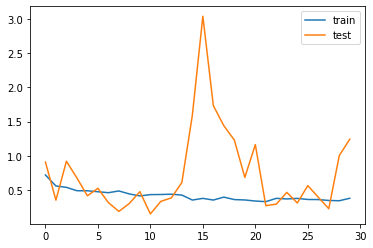

In [ ]:
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
model.load_weights("model-3-weights-improvement-04-0.68.hdf5")
predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))

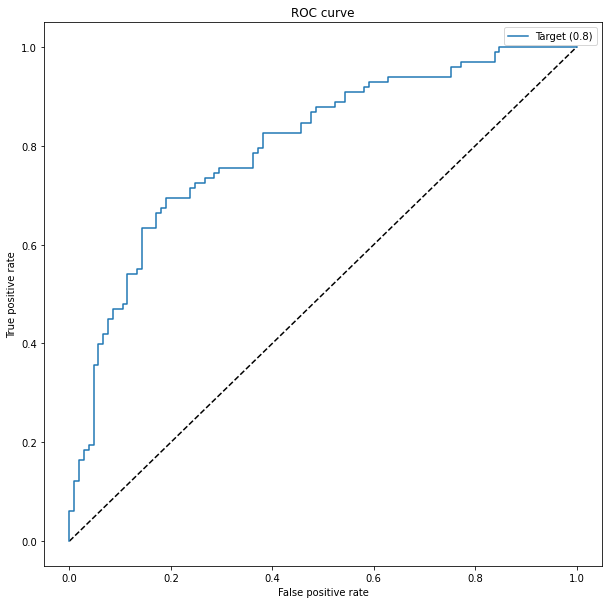

In [ ]:
auc_rocs = util.get_roc_curve(["Target"], predicted_vals, test_generator)

In [ ]:
gt = test_generator.labels[:, 0]
pred = predicted_vals[:, 0]
print(metrics.classification_report(gt, pred.round()))

              precision    recall  f1-score   support

           0       0.76      0.62      0.68       105
           1       0.66      0.80      0.72        98

    accuracy                           0.70       203
   macro avg       0.71      0.71      0.70       203
weighted avg       0.71      0.70      0.70       203



In [ ]:
f1_score = metrics.f1_score(gt, pred.round(), pos_label=1)
f1_score

0.7222222222222222

In [ ]:
tn, fp, fn, tp = metrics.confusion_matrix(gt, pred.round()).ravel()
sensitivity = tp / (tp+fn)
specificity = tn / (tn+fp)

In [ ]:
sensitivity

0.7959183673469388

In [ ]:
specificity

0.6190476190476191

In [ ]:
# create the base pre-trained model
base_model = DenseNet121(weights='./densenet.hdf5', include_top=False)

#mark loaded layers as not trainable
for layer in base_model.layers:
	layer.trainable = False

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# add a dense layer #1
x = Dense(64, activation='relu')(x)

# add a dropout layer
x = Dropout(0.5)(x)

# add a dense layer #1
x = Dense(32, activation='relu')(x)

# add a dropout layer
x = Dropout(0.5)(x)

# and a logistic layer
predictions = Dense(1, activation="sigmoid")(x)

In [ ]:
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss=BinaryCrossentropy(), metrics=[BinaryAccuracy()])

In [ ]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_11 (ZeroPadding2 (None, None, None, 3 0           input_6[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d_11[0][0]          
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
# Checkpoint
filepath="model-4-weights-improvement-{epoch:02d}-{val_binary_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_binary_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Generator Params
BS=8 
EPOCHS= 30
STEPS_PER_EPOCH=train_df.shape[0]//BS
VALIDATION_STEPS=val_df.shape[0]//BS

# Fit
history = model.fit_generator(train_generator, 
                              validation_data=valid_generator,
                              steps_per_epoch=100, 
                              validation_steps=VALIDATION_STEPS, 
                              epochs = EPOCHS,
                              callbacks=callbacks_list)

Epoch 1/30
100/100 [==============================] - 31s 305ms/step - loss: 0.7740 - binary_accuracy: 0.5229 - val_loss: 0.7169 - val_binary_accuracy: 0.5357

Epoch 00001: val_binary_accuracy improved from -inf to 0.53571, saving model to model-4-weights-improvement-01-0.54.hdf5
Epoch 2/30
100/100 [==============================] - 20s 202ms/step - loss: 0.6829 - binary_accuracy: 0.5674 - val_loss: 0.6061 - val_binary_accuracy: 0.4818

Epoch 00002: val_binary_accuracy did not improve from 0.53571
Epoch 3/30
100/100 [==============================] - 20s 204ms/step - loss: 0.6710 - binary_accuracy: 0.5827 - val_loss: 0.6973 - val_binary_accuracy: 0.5091

Epoch 00003: val_binary_accuracy did not improve from 0.53571
Epoch 4/30
100/100 [==============================] - 20s 203ms/step - loss: 0.6436 - binary_accuracy: 0.5941 - val_loss: 0.4979 - val_binary_accuracy: 0.4545

Epoch 00004: val_binary_accuracy did not improve from 0.53571
Epoch 5/30
100/100 [==============================] -

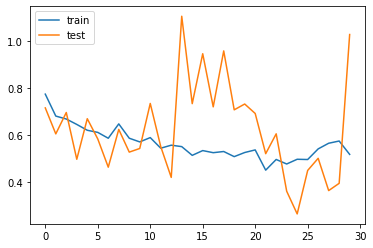

In [ ]:
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
model.load_weights("model-4-weights-improvement-17-0.62.hdf5")
predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))

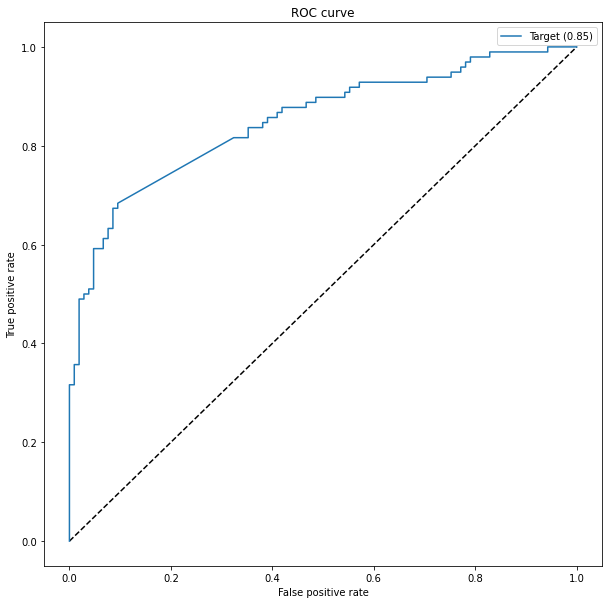

In [ ]:
auc_rocs = util.get_roc_curve(["Target"], predicted_vals, test_generator)

In [ ]:
gt = test_generator.labels[:, 0]
pred = predicted_vals[:, 0]
print(metrics.classification_report(gt, pred.round()))

              precision    recall  f1-score   support

           0       0.81      0.61      0.70       105
           1       0.67      0.85      0.75        98

    accuracy                           0.72       203
   macro avg       0.74      0.73      0.72       203
weighted avg       0.74      0.72      0.72       203



In [ ]:
f1_score = metrics.f1_score(gt, pred.round(), pos_label=1)
f1_score

0.7477477477477478

In [ ]:
tn, fp, fn, tp = metrics.confusion_matrix(gt, pred.round()).ravel()
sensitivity = tp / (tp+fn)
specificity = tn / (tn+fp)

In [ ]:
sensitivity

0.8469387755102041

In [ ]:
specificity

0.6095238095238096

In [ ]:
accuracy_score = metrics.accuracy_score(gt, pred.round(), normalize=True)
accuracy_score

0.7241379310344828

In [ ]:
# create the base pre-trained model
base_model = DenseNet121(weights='./densenet.hdf5', include_top=False)

#mark loaded layers as not trainable
for layer in base_model.layers:
	layer.trainable = False

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# add a dense layer #1
x = Dense(128, activation='relu')(x)

# add a dropout layer
x = Dropout(0.5)(x)

# add a dense layer #1
x = Dense(64, activation='relu')(x)

# add a dropout layer
x = Dropout(0.5)(x)

# and a logistic layer
predictions = Dense(1, activation="sigmoid")(x)

In [ ]:
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss=BinaryCrossentropy(), metrics=[BinaryAccuracy()])

In [ ]:
model.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_13 (ZeroPadding2 (None, None, None, 3 0           input_7[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d_13[0][0]          
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
# Checkpoint
filepath="model-5-weights-improvement-{epoch:02d}-{val_binary_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_binary_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Generator Params
BS=8 
EPOCHS= 30
STEPS_PER_EPOCH=train_df.shape[0]//BS
VALIDATION_STEPS=val_df.shape[0]//BS

# Fit
history = model.fit_generator(train_generator, 
                              validation_data=valid_generator,
                              steps_per_epoch=100, 
                              validation_steps=VALIDATION_STEPS, 
                              epochs = EPOCHS,
                              callbacks=callbacks_list)

Epoch 1/30
100/100 [==============================] - 30s 300ms/step - loss: 0.7902 - binary_accuracy: 0.5433 - val_loss: 0.7350 - val_binary_accuracy: 0.5089

Epoch 00001: val_binary_accuracy improved from -inf to 0.50893, saving model to model-5-weights-improvement-01-0.51.hdf5
Epoch 2/30
100/100 [==============================] - 20s 204ms/step - loss: 0.6459 - binary_accuracy: 0.6412 - val_loss: 0.3794 - val_binary_accuracy: 0.4545

Epoch 00002: val_binary_accuracy did not improve from 0.50893
Epoch 3/30
100/100 [==============================] - 21s 206ms/step - loss: 0.6514 - binary_accuracy: 0.5941 - val_loss: 0.7234 - val_binary_accuracy: 0.4818

Epoch 00003: val_binary_accuracy did not improve from 0.50893
Epoch 4/30
100/100 [==============================] - 20s 204ms/step - loss: 0.5950 - binary_accuracy: 0.6896 - val_loss: 0.4633 - val_binary_accuracy: 0.4727

Epoch 00004: val_binary_accuracy did not improve from 0.50893
Epoch 5/30
100/100 [==============================] -

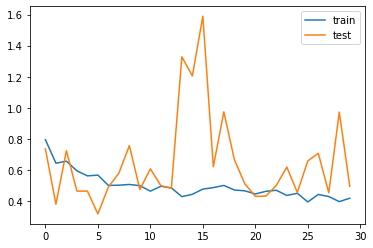

In [ ]:
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
model.load_weights("model-5-weights-improvement-19-0.66.hdf5")
predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))

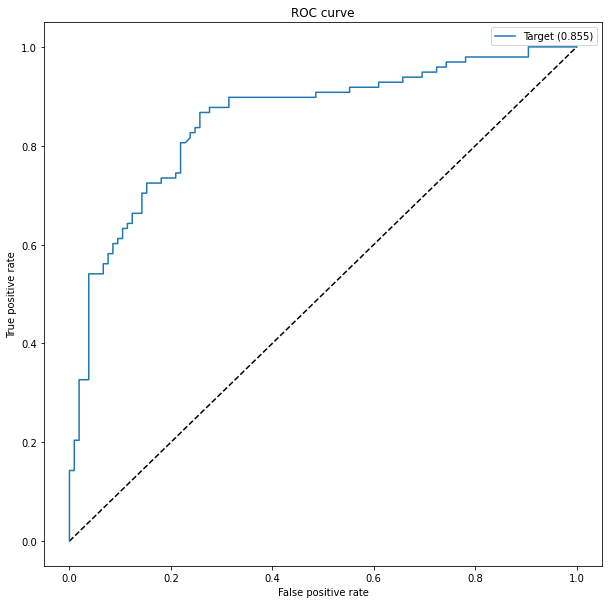

In [ ]:
auc_rocs = util.get_roc_curve(["Target"], predicted_vals, test_generator)

In [ ]:
gt = test_generator.labels[:, 0]
pred = predicted_vals[:, 0]
print(metrics.classification_report(gt, pred.round()))

              precision    recall  f1-score   support

           0       0.80      0.78      0.79       105
           1       0.77      0.80      0.78        98

    accuracy                           0.79       203
   macro avg       0.79      0.79      0.79       203
weighted avg       0.79      0.79      0.79       203



In [ ]:
f1_score = metrics.f1_score(gt, pred.round(), pos_label=1)
f1_score

0.7839195979899498

In [ ]:
tn, fp, fn, tp = metrics.confusion_matrix(gt, pred.round()).ravel()
sensitivity = tp / (tp+fn)
specificity = tn / (tn+fp)

In [ ]:
sensitivity

0.7959183673469388

In [ ]:
specificity

0.780952380952381

In [ ]:
accuracy_score = metrics.accuracy_score(gt, pred.round(), normalize=True)
accuracy_score

0.7881773399014779

In [ ]:
# create the base pre-trained model
base_model = DenseNet121(weights='./densenet.hdf5', include_top=False)

#mark loaded layers as not trainable
for layer in base_model.layers:
	layer.trainable = False

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# add a dense layer #1
x = Dense(256, activation='relu')(x)

# add a dropout layer
x = Dropout(0.5)(x)

# add a dense layer #1
x = Dense(128, activation='relu')(x)

# add a dropout layer
x = Dropout(0.5)(x)

# and a logistic layer
predictions = Dense(1, activation="sigmoid")(x)

In [ ]:
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss=BinaryCrossentropy(), metrics=[BinaryAccuracy()])

In [ ]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_15 (ZeroPadding2 (None, None, None, 3 0           input_8[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d_15[0][0]          
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
# Checkpoint
filepath="model-5-weights-improvement-{epoch:02d}-{val_binary_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_binary_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Generator Params
BS=8 
EPOCHS= 30
STEPS_PER_EPOCH=train_df.shape[0]//BS
VALIDATION_STEPS=val_df.shape[0]//BS

# Fit
history = model.fit_generator(train_generator, 
                              validation_data=valid_generator,
                              steps_per_epoch=100, 
                              validation_steps=VALIDATION_STEPS, 
                              epochs = EPOCHS,
                              callbacks=callbacks_list)

Epoch 1/30
100/100 [==============================] - 32s 319ms/step - loss: 0.8449 - binary_accuracy: 0.5483 - val_loss: 0.6435 - val_binary_accuracy: 0.4464

Epoch 00001: val_binary_accuracy improved from -inf to 0.44643, saving model to model-5-weights-improvement-01-0.45.hdf5
Epoch 2/30
100/100 [==============================] - 21s 206ms/step - loss: 0.6324 - binary_accuracy: 0.6590 - val_loss: 0.5137 - val_binary_accuracy: 0.5182

Epoch 00002: val_binary_accuracy improved from 0.44643 to 0.51818, saving model to model-5-weights-improvement-02-0.52.hdf5
Epoch 3/30
100/100 [==============================] - 20s 203ms/step - loss: 0.5331 - binary_accuracy: 0.7468 - val_loss: 1.2519 - val_binary_accuracy: 0.6000

Epoch 00003: val_binary_accuracy improved from 0.51818 to 0.60000, saving model to model-5-weights-improvement-03-0.60.hdf5
Epoch 4/30
100/100 [==============================] - 20s 203ms/step - loss: 0.5812 - binary_accuracy: 0.7112 - val_loss: 0.6179 - val_binary_accuracy:

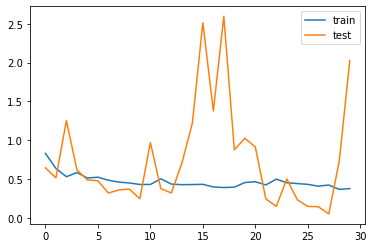

In [ ]:
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
model.load_weights("model-5-weights-improvement-19-0.66.hdf5")
predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))

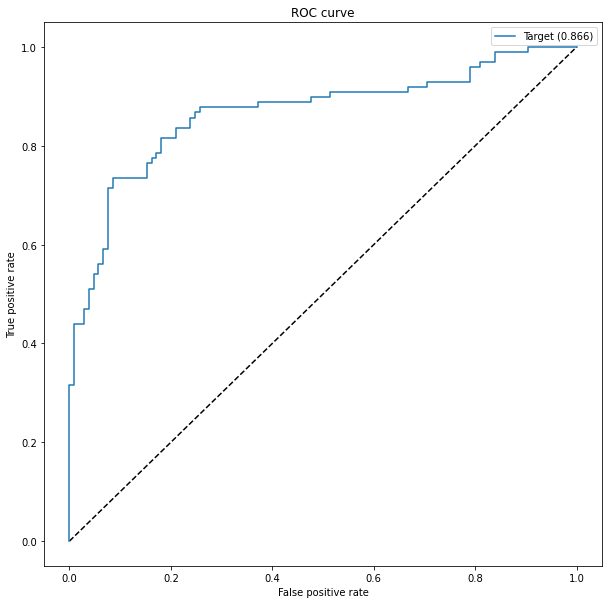

In [ ]:
auc_rocs = util.get_roc_curve(["Target"], predicted_vals, test_generator)

In [ ]:
gt = test_generator.labels[:, 0]
pred = predicted_vals[:, 0]
print(metrics.classification_report(gt, pred.round()))

              precision    recall  f1-score   support

           0       0.84      0.47      0.60       105
           1       0.61      0.91      0.73        98

    accuracy                           0.68       203
   macro avg       0.73      0.69      0.67       203
weighted avg       0.73      0.68      0.66       203



In [ ]:
tn, fp, fn, tp = metrics.confusion_matrix(gt, pred.round()).ravel()
sensitivity = tp / (tp+fn)
specificity = tn / (tn+fp)

In [ ]:
sensitivity

0.9081632653061225

In [ ]:
specificity

0.4666666666666667

In [ ]:
accuracy_score = metrics.accuracy_score(gt, pred.round(), normalize=True)
accuracy_score

0.6798029556650246

In [ ]:
f1_score = metrics.f1_score(gt, pred.round(), pos_label=1)
f1_score

0.7325102880658436

In [ ]:
# create the base pre-trained model
base_model = DenseNet121(weights='./densenet.hdf5', include_top=False)

#mark loaded layers as not trainable
for layer in base_model.layers:
	layer.trainable = False

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# add a dense layer #1
x = Dense(256, activation='relu')(x)

# add a dropout layer
x = Dropout(0.5)(x)

# add a dense layer #1
x = Dense(128, activation='relu')(x)

# add a dropout layer
x = Dropout(0.5)(x)

# add a dense layer #1
x = Dense(64, activation='relu')(x)

# add a dropout layer
x = Dropout(0.5)(x)

# and a logistic layer
predictions = Dense(1, activation="sigmoid")(x)

In [ ]:
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss=BinaryCrossentropy(), metrics=[BinaryAccuracy()])

In [ ]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_17 (ZeroPadding2 (None, None, None, 3 0           input_9[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d_17[0][0]          
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
# Checkpoint
filepath="model-6-weights-improvement-{epoch:02d}-{val_binary_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_binary_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Generator Params
BS=8 
EPOCHS= 50
STEPS_PER_EPOCH=train_df.shape[0]//BS
VALIDATION_STEPS=val_df.shape[0]//BS

# Fit
history = model.fit_generator(train_generator, 
                              validation_data=valid_generator,
                              steps_per_epoch=100, 
                              validation_steps=VALIDATION_STEPS, 
                              epochs = EPOCHS,
                              callbacks=callbacks_list)

Epoch 1/50
100/100 [==============================] - 25s 246ms/step - loss: 0.8420 - binary_accuracy: 0.5624 - val_loss: 0.5298 - val_binary_accuracy: 0.4643

Epoch 00001: val_binary_accuracy improved from -inf to 0.46429, saving model to model-6-weights-improvement-01-0.46.hdf5
Epoch 2/50
100/100 [==============================] - 20s 202ms/step - loss: 0.7014 - binary_accuracy: 0.5956 - val_loss: 0.6353 - val_binary_accuracy: 0.5455

Epoch 00002: val_binary_accuracy improved from 0.46429 to 0.54545, saving model to model-6-weights-improvement-02-0.55.hdf5
Epoch 3/50
100/100 [==============================] - 20s 204ms/step - loss: 0.6593 - binary_accuracy: 0.6221 - val_loss: 0.6706 - val_binary_accuracy: 0.5000

Epoch 00003: val_binary_accuracy did not improve from 0.54545
Epoch 4/50
100/100 [==============================] - 21s 207ms/step - loss: 0.6104 - binary_accuracy: 0.6858 - val_loss: 0.5328 - val_binary_accuracy: 0.4545

Epoch 00004: val_binary_accuracy did not improve from

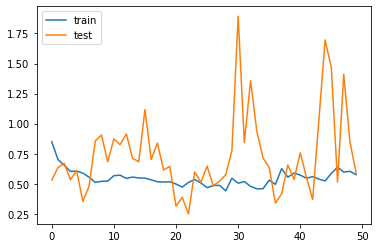

In [ ]:
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
model.load_weights("model-6-weights-improvement-49-0.65.hdf5")
predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))

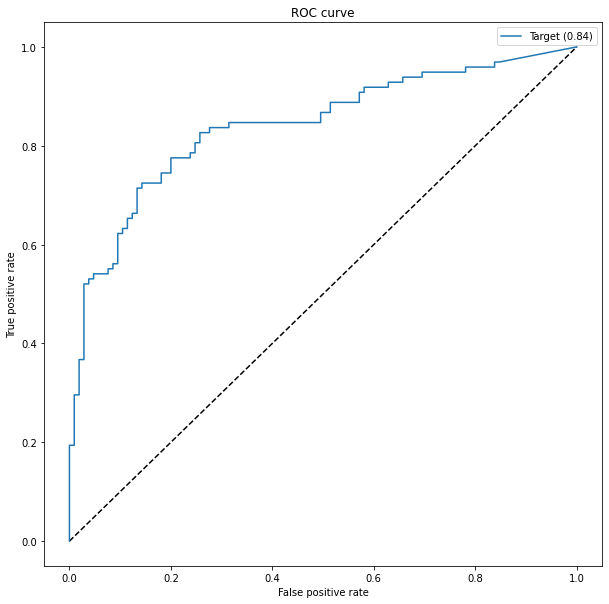

In [ ]:
auc_rocs = util.get_roc_curve(["Target"], predicted_vals, test_generator)

In [ ]:
gt = test_generator.labels[:, 0]
pred = predicted_vals[:, 0]
print(metrics.classification_report(gt, pred.round()))

              precision    recall  f1-score   support

           0       0.83      0.43      0.57       105
           1       0.60      0.91      0.72        98

    accuracy                           0.66       203
   macro avg       0.72      0.67      0.64       203
weighted avg       0.72      0.66      0.64       203



In [ ]:
tn, fp, fn, tp = metrics.confusion_matrix(gt, pred.round()).ravel()
sensitivity = tp / (tp+fn)
specificity = tn / (tn+fp)

In [ ]:
sensitivity

0.9081632653061225

In [ ]:
specificity

0.42857142857142855

In [ ]:
accuracy_score = metrics.accuracy_score(gt, pred.round(), normalize=True)
accuracy_score

0.6600985221674877

In [ ]:
f1_score = metrics.f1_score(gt, pred.round(), pos_label=1)
f1_score

0.7206477732793521

In [ ]:
# create the base pre-trained model
base_model = DenseNet121(weights='./densenet.hdf5', include_top=False)

#mark loaded layers as not trainable
for layer in base_model.layers:
	layer.trainable = False

x = base_model.output

# add a global spatial average pooling layer
x = GlobalAveragePooling2D()(x)

# add a dense layer #1
x = Dense(256, activation='relu')(x)

# add a dropout layer
x = Dropout(0.5)(x)

# add a dense layer #1
x = Dense(64, activation='relu')(x)

# add a dropout layer
x = Dropout(0.5)(x)

# and a logistic layer
predictions = Dense(1, activation="sigmoid")(x)

In [ ]:
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer='adam', loss=BinaryCrossentropy(), metrics=[BinaryAccuracy()])

In [ ]:
model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_11 (InputLayer)           (None, None, None, 3 0                                            
__________________________________________________________________________________________________
zero_padding2d_21 (ZeroPadding2 (None, None, None, 3 0           input_11[0][0]                   
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, None, None, 6 9408        zero_padding2d_21[0][0]          
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, None, None, 6 256         conv1/conv[0][0]                 
___________________________________________________________________________________________

In [ ]:
# Checkpoint
filepath="model-6-weights-improvement-{epoch:02d}-{val_binary_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_binary_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

# Generator Params
BS=8 
EPOCHS= 50
STEPS_PER_EPOCH=train_df.shape[0]//BS
VALIDATION_STEPS=val_df.shape[0]//BS

# Fit
history = model.fit_generator(train_generator, 
                              validation_data=valid_generator,
                              steps_per_epoch=100, 
                              validation_steps=VALIDATION_STEPS, 
                              epochs = EPOCHS,
                              callbacks=callbacks_list)

Epoch 1/50
100/100 [==============================] - 33s 326ms/step - loss: 0.8604 - binary_accuracy: 0.5394 - val_loss: 0.8362 - val_binary_accuracy: 0.5089

Epoch 00001: val_binary_accuracy improved from -inf to 0.50893, saving model to model-6-weights-improvement-01-0.51.hdf5
Epoch 2/50
100/100 [==============================] - 20s 204ms/step - loss: 0.6413 - binary_accuracy: 0.6310 - val_loss: 0.7257 - val_binary_accuracy: 0.5909

Epoch 00002: val_binary_accuracy improved from 0.50893 to 0.59091, saving model to model-6-weights-improvement-02-0.59.hdf5
Epoch 3/50
100/100 [==============================] - 20s 203ms/step - loss: 0.6043 - binary_accuracy: 0.6781 - val_loss: 0.7264 - val_binary_accuracy: 0.4727

Epoch 00003: val_binary_accuracy did not improve from 0.59091
Epoch 4/50
100/100 [==============================] - 21s 205ms/step - loss: 0.5700 - binary_accuracy: 0.7049 - val_loss: 0.5819 - val_binary_accuracy: 0.6364

Epoch 00004: val_binary_accuracy improved from 0.5909

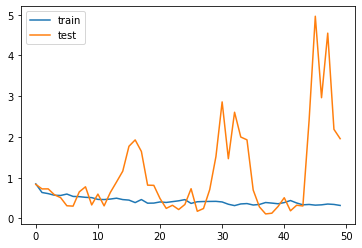

In [ ]:
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

In [ ]:
model.load_weights("model-6-weights-improvement-16-0.64.hdf5")
predicted_vals = model.predict_generator(test_generator, steps = len(test_generator))

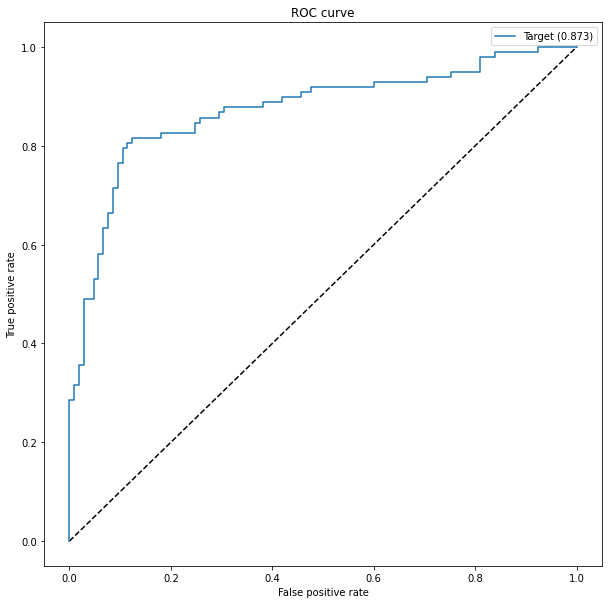

In [ ]:
auc_rocs = util.get_roc_curve(["Target"], predicted_vals, test_generator)

In [ ]:
gt = test_generator.labels[:, 0]
pred = predicted_vals[:, 0]
print(metrics.classification_report(gt, pred.round()))

              precision    recall  f1-score   support

           0       0.85      0.63      0.72       105
           1       0.69      0.88      0.77        98

    accuracy                           0.75       203
   macro avg       0.77      0.75      0.75       203
weighted avg       0.77      0.75      0.75       203



In [ ]:
f1_score = metrics.f1_score(gt, pred.round(), pos_label=1)
f1_score

0.7713004484304932

In [ ]:
tn, fp, fn, tp = metrics.confusion_matrix(gt, pred.round()).ravel()
sensitivity = tp / (tp+fn)
specificity = tn / (tn+fp)

In [ ]:
sensitivity

0.8775510204081632

In [ ]:
specificity

0.6285714285714286

In [ ]:
accuracy_score = metrics.accuracy_score(gt, pred.round(), normalize=True)
accuracy_score

0.7487684729064039